* *DATA CLEANING*
* *DATA IMPUTATION (NaN imputation, Zeros imputation)*
* *FEATURE SELECTION (Pearson, RFE)*
* *NO GRID SEARCH*

In [1]:
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and pla

In [2]:
!pip install missingno

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [4]:
import time
import pickle
import missingno as msno
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [5]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Preprocessing and feature engineering of the collected data

In [7]:
# Load data
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv

--2025-02-09 01:22:02--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/docking_results/docking_scores_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338231 (330K) [text/plain]
Saving to: ‘docking_scores_data.csv’

docking_scores_data 100%[===================>] 330.30K  --.-KB/s    in 0.04s   

2025-02-09 01:22:02 (7.60 MB/s) - ‘docking_scores_data.csv’ saved [338231/338231]

--2025-02-09 01:22:03--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/descriptors_data/RDKit_descriptors.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

In [8]:
df = pd.read_csv("docking_scores_data.csv")
df.columns

Index(['smiles', 'Delta_Gibbs'], dtype='object')

In [9]:
# Handling missing data && cleaning
df = df.dropna(subset=['Delta_Gibbs'])
df = df.drop_duplicates(['smiles']).reset_index(drop=True)
df.shape

(8515, 2)

In [10]:
# Load RDKit descriptors
RDKit_df = pd.read_csv("RDKit_descriptors.csv")
RDKit_df.shape

(8515, 210)

In [11]:
# Load PaDEL descriptors
PaDEL_df = pd.read_csv("PaDEL_descriptors.csv")
PaDEL_df.shape

(8515, 1444)

### Exploratory Data Analysis (EDA)

**Frequency plot of Delta Gibbs**

Text(0, 0.5, 'Frequency')

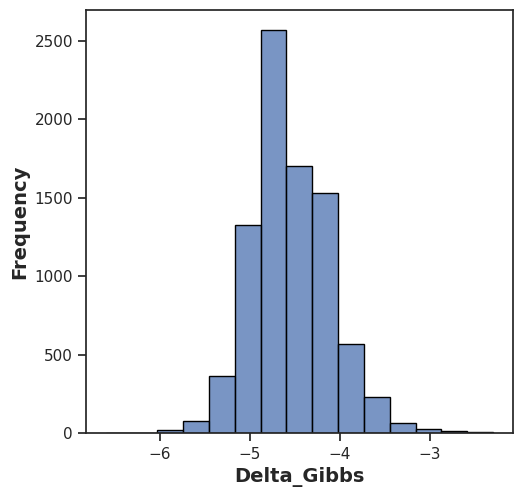

In [12]:
plt.figure(figsize=(5.5, 5.5))

sns.histplot(x='Delta_Gibbs', data=df, bins=15, edgecolor='black')

plt.xlabel('Delta_Gibbs', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# plt.savefig('plot_bioactivity_class.pdf')

**Delta Gibbs Box plot**


Text(0, 0.5, 'Delta_Gibbs')

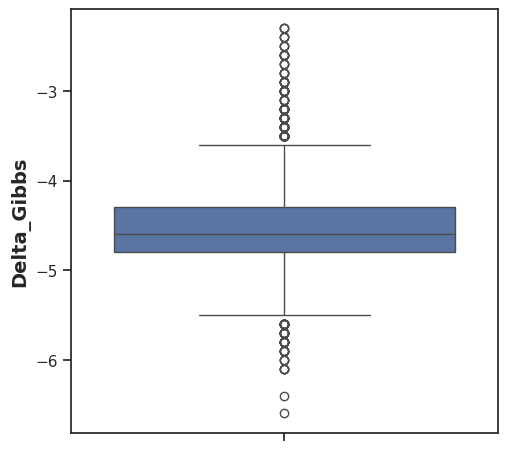

In [13]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(y='Delta_Gibbs', data=df)

plt.ylabel('Delta_Gibbs', fontsize=14, fontweight='bold')

**Descriptors Box Plot**

<Axes: >

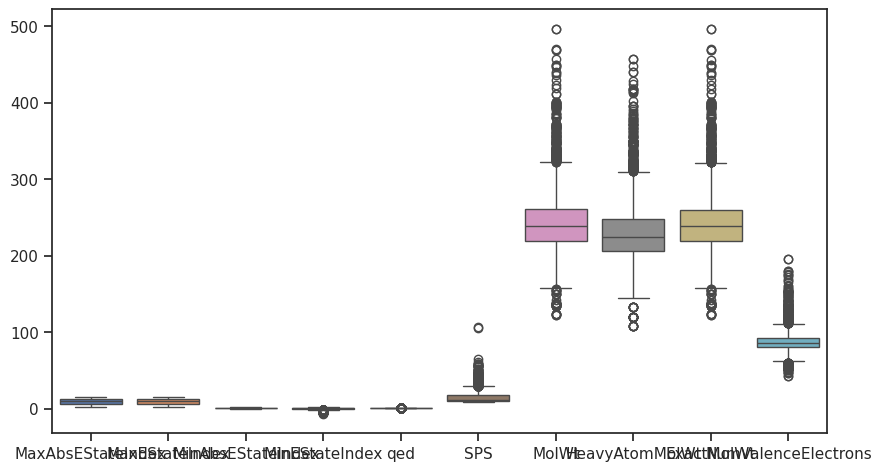

In [14]:
# RDKit
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=RDKit_df.iloc[:,:10])

<Axes: >

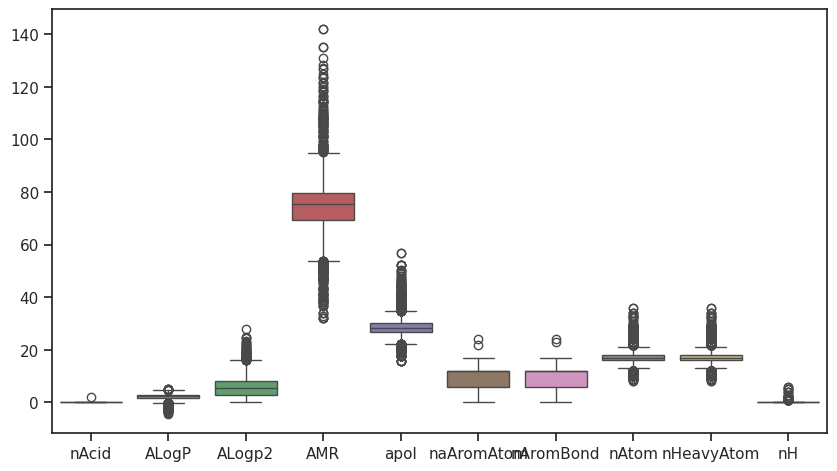

In [15]:
# PaDEL
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=PaDEL_df.iloc[:,:10])

**NaN Visualization**

<Axes: >

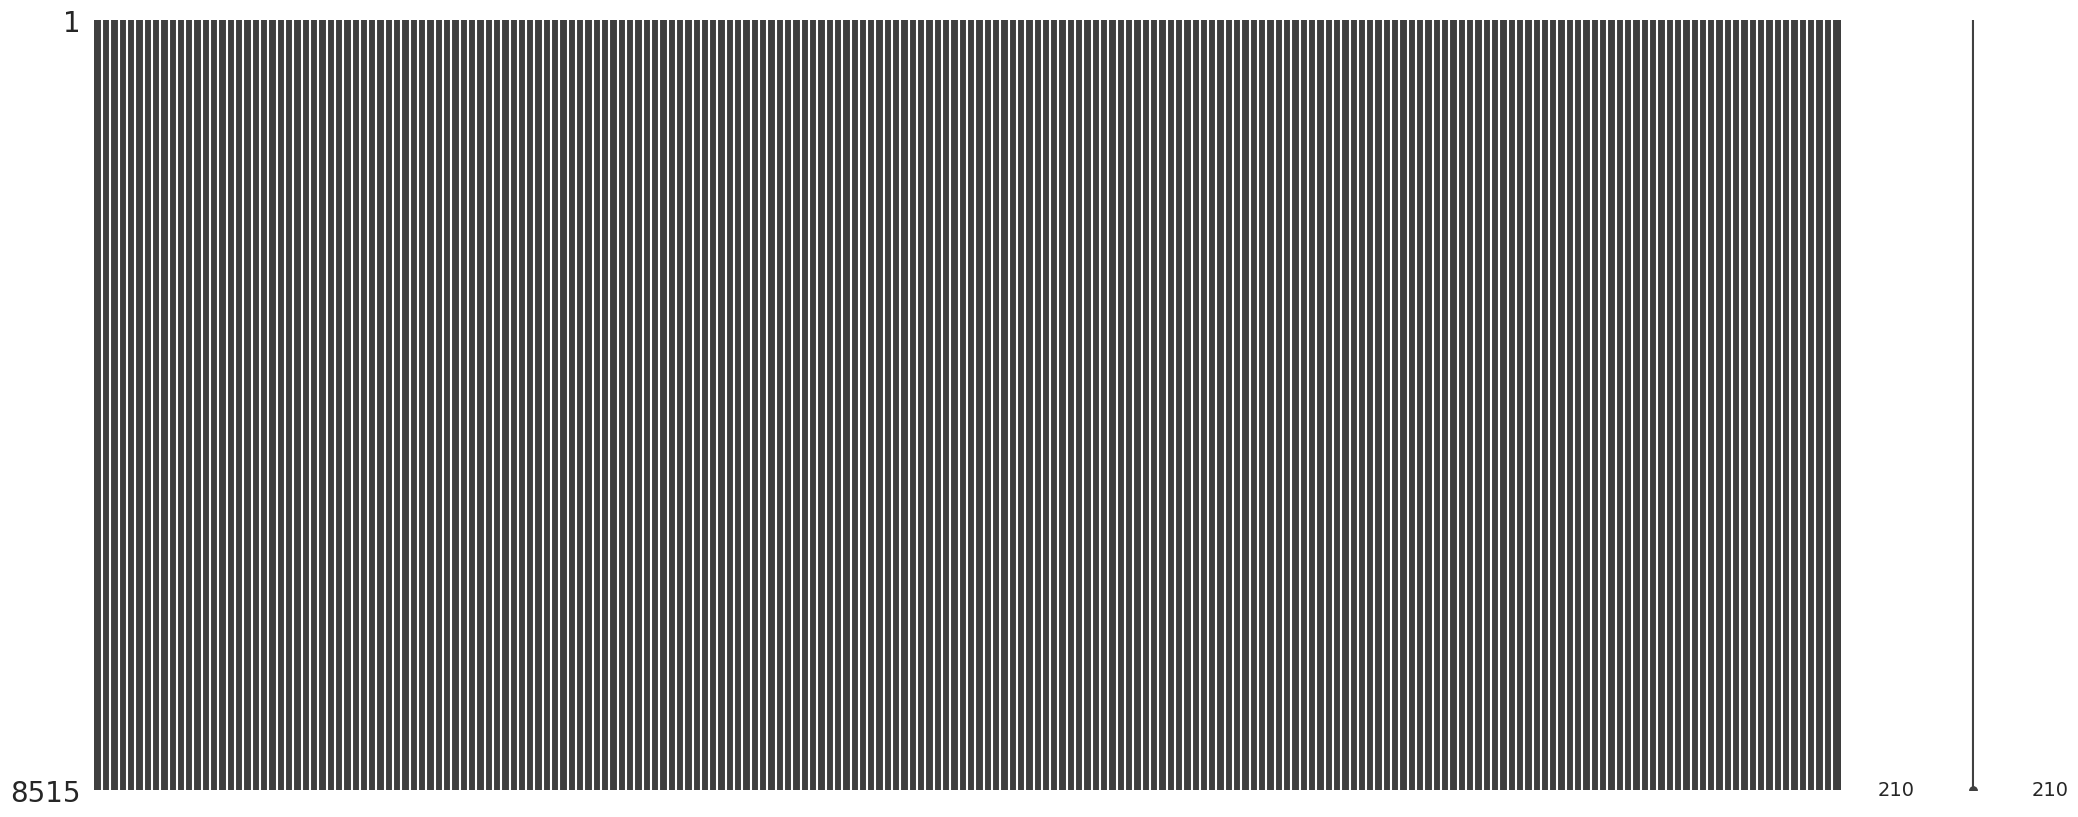

In [16]:
# RDKit
msno.matrix(RDKit_df)

<Axes: >

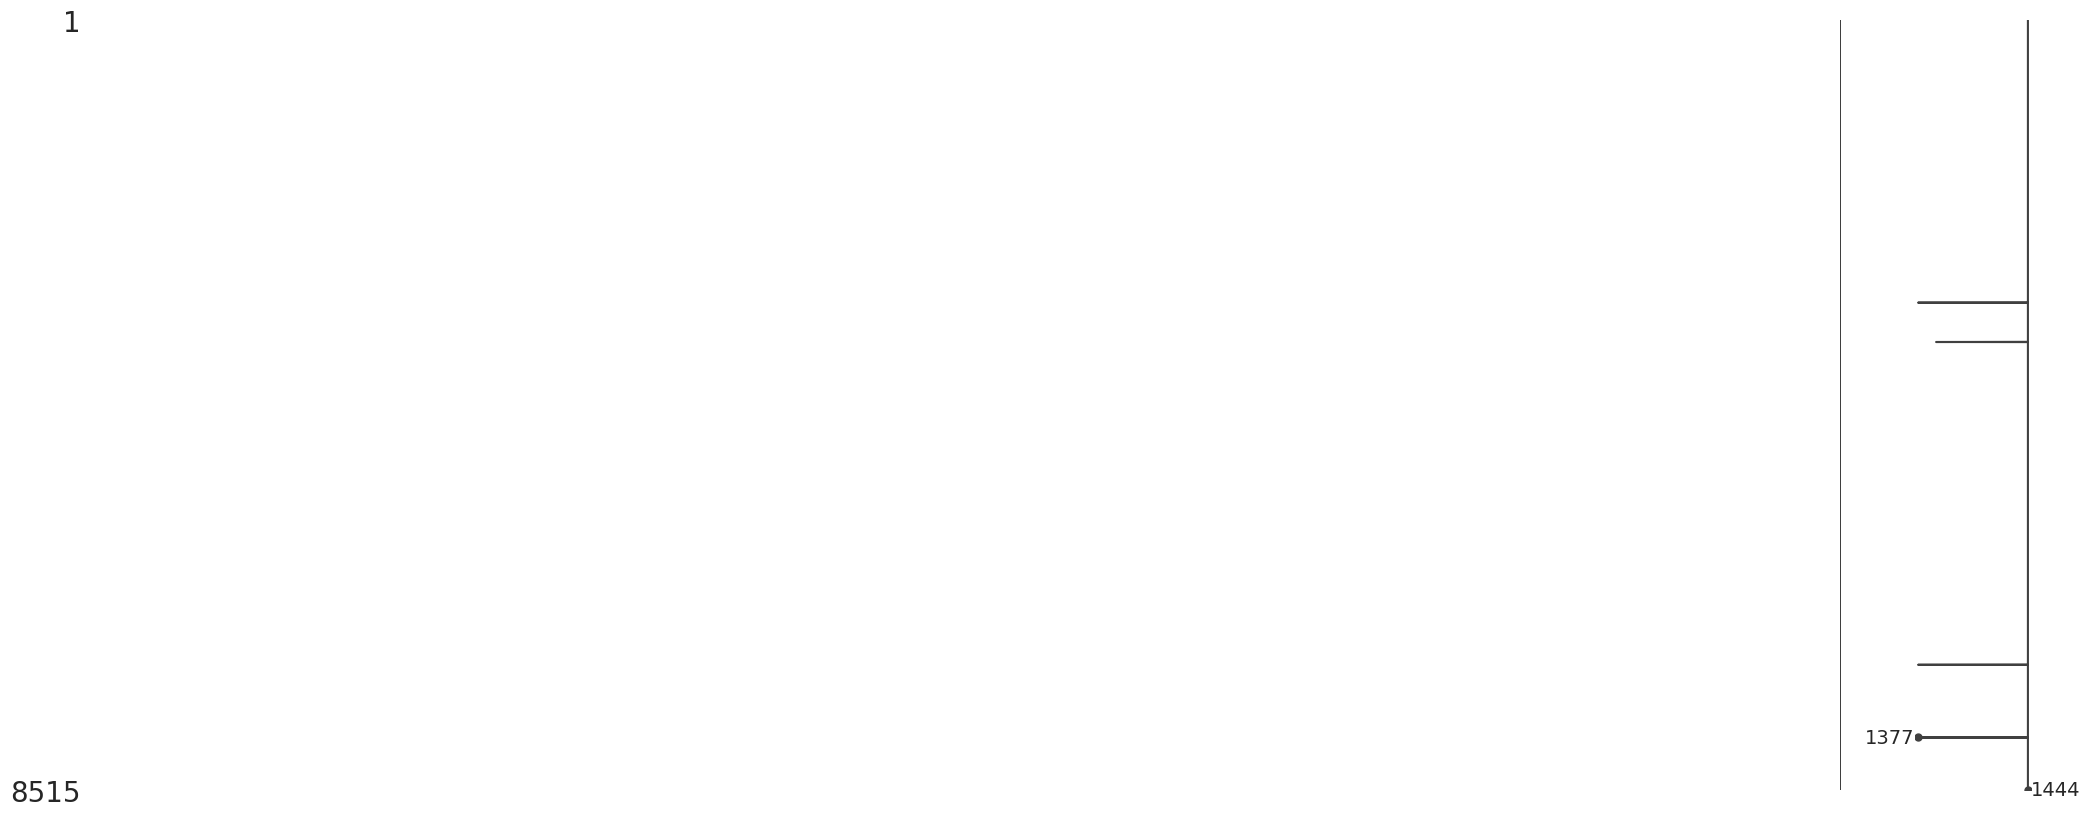

In [17]:
# PaDEL
msno.matrix(PaDEL_df)

### Data Cleaning and Imputation

**RDKit**

In [18]:
RDKit_df.shape

(8515, 210)

In [19]:
# Drop columns with 90% NaN
RDKit_df = RDKit_df.loc[:, RDKit_df.isna().mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 210)

In [20]:
# fill NaN values with the median of each column
RDKit_df.fillna(RDKit_df.median(), inplace=True)
RDKit_df.shape

(8515, 210)

In [21]:
# Drop columns with 90% zeros
RDKit_df = RDKit_df.loc[:, (RDKit_df == 0).mean(axis=0) < 0.9]
RDKit_df.shape

(8515, 129)

**PaDEL**

In [22]:
PaDEL_df.shape

(8515, 1444)

In [23]:
# Drop columns with 90% NaN
PaDEL_df = PaDEL_df.loc[:, PaDEL_df.isna().mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 1444)

In [24]:
# fill NaN values with the median of each column
PaDEL_df.fillna(PaDEL_df.median(), inplace=True)
PaDEL_df.shape

(8515, 1444)

In [25]:
# Drop columns with 90% zeros
PaDEL_df = PaDEL_df.loc[:, (PaDEL_df == 0).mean(axis=0) < 0.9]
PaDEL_df.shape

(8515, 928)

### Data Transformation

In [26]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [27]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit_df)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)
PaDEL_scaled = robust_scaler.fit_transform(PaDEL_df)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

In [28]:
# Create RDKit scaled DataFrame
RDKit_columns = RDKit_df.columns
RDKit_scaled_df = pd.DataFrame(RDKit_scaled)
RDKit_scaled_df.columns = RDKit_columns
RDKit_scaled_df.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_NH0,fr_allylic_oxid,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_para_hydroxylation,fr_sulfide
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.50,0.50,0.32,0.81,0.66,0.07,0.32,0.35,0.32,0.28,...,0.07,0.03,0.09,0.51,0.04,0.02,0.07,0.09,0.06,0.03
std,0.28,0.28,0.24,0.15,0.13,0.07,0.09,0.10,0.09,0.08,...,0.12,0.08,0.15,0.20,0.09,0.07,0.12,0.13,0.14,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.27,0.12,0.77,0.57,0.02,0.26,0.28,0.26,0.25,...,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.63,0.63,0.25,0.83,0.68,0.03,0.31,0.33,0.31,0.29,...,0.00,0.00,0.00,0.67,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.76,0.76,0.49,0.91,0.75,0.10,0.37,0.40,0.37,0.32,...,0.20,0.00,0.20,0.67,0.00,0.00,0.20,0.11,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [29]:
# Create PaDEL scaled DataFrame
PaDEL_columns = PaDEL_df.columns
PaDEL_scaled_df = pd.DataFrame(PaDEL_scaled)
PaDEL_scaled_df.columns = PaDEL_columns
PaDEL_scaled_df.describe()

,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nC,nN,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
count,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,...,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00,8515.00
mean,0.67,0.20,0.38,0.31,0.42,0.42,0.31,0.31,0.45,0.06,...,0.20,0.32,0.31,0.27,0.09,0.06,0.12,0.26,0.45,0.28
std,0.11,0.13,0.08,0.08,0.14,0.14,0.08,0.08,0.08,0.09,...,0.08,0.08,0.07,0.17,0.10,0.10,0.06,0.09,0.10,0.09
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.61,0.10,0.34,0.27,0.25,0.25,0.29,0.29,0.40,0.00,...,0.15,0.29,0.27,0.12,0.00,0.00,0.09,0.21,0.39,0.22
50%,0.69,0.19,0.39,0.31,0.50,0.50,0.32,0.32,0.44,0.00,...,0.19,0.33,0.30,0.23,0.09,0.00,0.11,0.26,0.44,0.26
75%,0.74,0.29,0.43,0.35,0.50,0.50,0.36,0.36,0.48,0.14,...,0.23,0.37,0.34,0.36,0.12,0.14,0.14,0.31,0.51,0.32
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Feature Selection : Pearson

In [30]:
# Concat RDKit and PaDEL descriptors
RDKit_PaDEL_df = pd.concat([RDKit_scaled_df,PaDEL_scaled_df], axis = 1)

In [31]:
# Calculate the correlation matrix
corr_matrix = RDKit_PaDEL_df.corr().abs()

<Axes: >

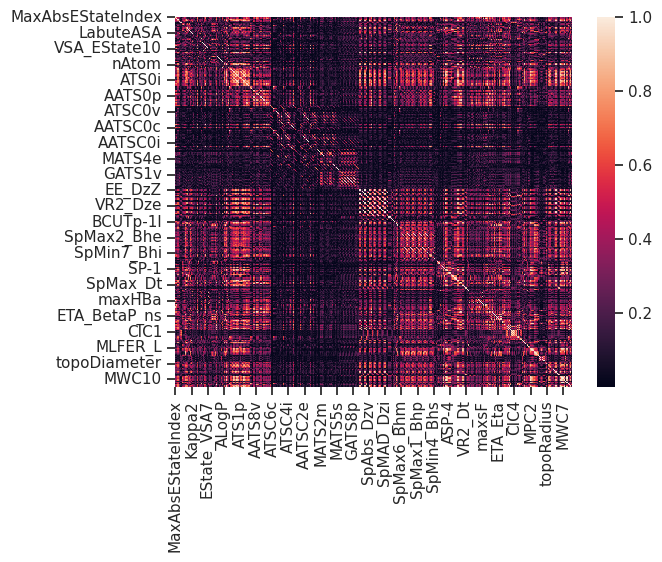

In [32]:
sns.heatmap(corr_matrix)

In [33]:
# Select columns with more than 90% correlation (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns with correlation > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# Drop highly correlated columns
RDKit_PaDEL_cleaned_df = RDKit_PaDEL_df.drop(columns=to_drop)
RDKit_PaDEL_cleaned_df

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE3_D,VR1_D,TopoPSA,SRW5,XLogP
0,0.77,0.28,0.40,0.82,0.07,0.41,0.38,0.42,0.61,0.53,...,0.33,0.55,0.00,0.00,0.02,0.91,0.00,0.26,0.71,0.22
1,0.72,0.21,0.40,0.76,0.03,0.32,0.23,0.36,0.79,0.53,...,0.92,0.00,0.00,0.00,0.08,0.95,0.00,0.23,0.00,0.34
2,0.76,0.24,0.39,0.89,0.03,0.42,0.39,0.42,0.61,0.41,...,0.60,0.00,0.00,0.00,0.02,0.91,0.00,0.26,0.00,0.24
3,0.67,0.03,0.76,0.61,0.02,0.29,0.29,0.46,0.67,0.67,...,1.00,0.00,0.00,0.00,0.30,0.97,0.00,0.32,0.00,0.30
4,0.76,0.13,0.37,0.95,0.06,0.41,0.36,0.44,0.67,0.62,...,0.74,0.00,0.00,0.00,0.21,0.96,0.00,0.34,0.46,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.01,0.82,0.96,0.04,0.48,0.47,0.32,0.45,0.53,...,0.52,0.57,0.45,0.57,0.17,0.94,0.00,0.15,0.00,0.35
8511,0.57,0.11,0.84,0.88,0.02,0.44,0.44,0.32,0.45,0.46,...,0.43,0.42,0.38,0.28,0.13,0.94,0.00,0.15,0.00,0.41
8512,0.63,0.01,0.82,0.76,0.03,0.48,0.47,0.34,0.45,0.50,...,0.65,0.38,0.31,0.00,0.11,0.94,0.00,0.15,0.00,0.38
8513,0.62,0.03,0.82,0.70,0.04,0.40,0.39,0.34,0.45,0.65,...,0.72,0.38,0.31,0.00,0.02,0.91,0.00,0.10,0.00,0.36


### Merge descriptors dataframes with Delta Gibbs scores

In [34]:
RDKit_PaDEL = pd.concat([RDKit_PaDEL_cleaned_df,df['Delta_Gibbs']], axis = 1)
RDKit_PaDEL

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,JGI8,JGI9,JGI10,VE1_D,VE3_D,VR1_D,TopoPSA,SRW5,XLogP,Delta_Gibbs
0,0.77,0.28,0.40,0.82,0.07,0.41,0.38,0.42,0.61,0.53,...,0.55,0.00,0.00,0.02,0.91,0.00,0.26,0.71,0.22,-4.20
1,0.72,0.21,0.40,0.76,0.03,0.32,0.23,0.36,0.79,0.53,...,0.00,0.00,0.00,0.08,0.95,0.00,0.23,0.00,0.34,-4.20
2,0.76,0.24,0.39,0.89,0.03,0.42,0.39,0.42,0.61,0.41,...,0.00,0.00,0.00,0.02,0.91,0.00,0.26,0.00,0.24,-4.20
3,0.67,0.03,0.76,0.61,0.02,0.29,0.29,0.46,0.67,0.67,...,0.00,0.00,0.00,0.30,0.97,0.00,0.32,0.00,0.30,-4.50
4,0.76,0.13,0.37,0.95,0.06,0.41,0.36,0.44,0.67,0.62,...,0.00,0.00,0.00,0.21,0.96,0.00,0.34,0.46,0.14,-4.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.01,0.82,0.96,0.04,0.48,0.47,0.32,0.45,0.53,...,0.57,0.45,0.57,0.17,0.94,0.00,0.15,0.00,0.35,-4.90
8511,0.57,0.11,0.84,0.88,0.02,0.44,0.44,0.32,0.45,0.46,...,0.42,0.38,0.28,0.13,0.94,0.00,0.15,0.00,0.41,-4.70
8512,0.63,0.01,0.82,0.76,0.03,0.48,0.47,0.34,0.45,0.50,...,0.38,0.31,0.00,0.11,0.94,0.00,0.15,0.00,0.38,-4.70
8513,0.62,0.03,0.82,0.70,0.04,0.40,0.39,0.34,0.45,0.65,...,0.38,0.31,0.00,0.02,0.91,0.00,0.10,0.00,0.36,-5.10


### Prepare the output/input dataframes

*   **Input:** RDKit & PaDEL descriptors
*   **Output:** Delta Gibbs value

In [35]:
# RDKit & PaDEL
input = RDKit_PaDEL.iloc[:,:-1]
output = RDKit_PaDEL.iloc[:,-1]

In [ ]:
# Split the data to training and testing
# X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(input_3, output_3, test_size=0.30, random_state=3) # RDKit & PaDEL

## Apply Machine Learning Algorithms

### Apply Regressors

In [ ]:
# Regression models
models_ml = {
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(verbosity=-1),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "KernelRidge": KernelRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

In [ ]:
# Train regression models
print("{:>30} {:>30}".format("MODEL", "SCORE"))
for name, mdl in models_ml.items():
    try:
        kf = KFold(n_splits=5)
        score = cross_val_score(mdl, input, output, cv=kf, scoring='r2')
        show_values = [name, np.round(np.mean(score), 2)]
        print("{:>30} {:>30}".format(*show_values), np.round(score, 2))
    except Exception as e:
        print("{:>30} {:>30}".format(name, "error"))

                         MODEL                          SCORE
 HistGradientBoostingRegressor                           0.76 [0.79 0.79 0.79 0.74 0.66]
                 LGBMRegressor                           0.75 [0.81 0.79 0.79 0.74 0.64]
                           SVR                           0.76 [0.82 0.81 0.78 0.72 0.69]
                         NuSVR                           0.76 [0.82 0.81 0.78 0.72 0.69]
                HuberRegressor                           0.74 [0.82 0.79 0.74 0.68 0.69]
           ExtraTreesRegressor                           0.74 [0.77 0.78 0.77 0.72 0.68]


### Recursive Feature Elimination (RFE)

In [ ]:
# HistGradientBoostingRegressor = HistGradientBoostingRegressor()
LGBMRegressor = LGBMRegressor(verbosity=-1)
# SVR = SVR()
# NuSVR = NuSVR()
# KernelRidge = KernelRidge()
HuberRegressor = HuberRegressor()
ExtraTreesRegressor = ExtraTreesRegressor()

#### LGBMRegressor

In [ ]:
# RFE LGBM Regressor
selector_LGBM = RFECV(LGBMRegressor, step=15,
                 min_features_to_select=50,
                 cv=5,
                 verbose=4
                 )

selector_LGBM.fit(input,output)

Fitting estimator with 530 features.
Fitting estimator with 515 features.
Fitting estimator with 500 features.
Fitting estimator with 485 features.
Fitting estimator with 470 features.
Fitting estimator with 455 features.
Fitting estimator with 440 features.
Fitting estimator with 425 features.
Fitting estimator with 410 features.
Fitting estimator with 395 features.
Fitting estimator with 380 features.
Fitting estimator with 365 features.
Fitting estimator with 350 features.
Fitting estimator with 335 features.
Fitting estimator with 320 features.
Fitting estimator with 305 features.
Fitting estimator with 290 features.
Fitting estimator with 275 features.
Fitting estimator with 260 features.
Fitting estimator with 245 features.
Fitting estimator with 230 features.
Fitting estimator with 215 features.
Fitting estimator with 200 features.
Fitting estimator with 185 features.
Fitting estimator with 170 features.
Fitting estimator with 155 features.
Fitting estimator with 140 features.
F

RFECV(cv=5, estimator=LGBMRegressor(verbosity=-1), min_features_to_select=50,
      step=15, verbose=4)

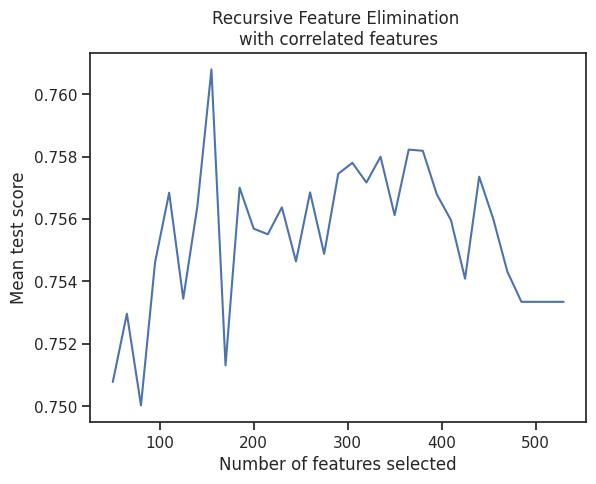

In [ ]:
# Plot results
cv_results = pd.DataFrame(selector_LGBM.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
# Number of features selected
selector_LGBM.n_features_

155

In [ ]:
# Save model
with open("selector_LGBM.pickle", "wb") as fh:
  pickle.dump(selector_LGBM, fh)

In [36]:
# Load model
with open(r"selector_LGBM.pickle", "rb") as input_file:
  selector_LGBM = pickle.load(input_file)

In [37]:
# Create new DF with selected features
input_LGBM = input.iloc[:,selector_LGBM.get_support()]
input_LGBM

,MaxAbsEStateIndex,qed,SPS,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPLOW,...,JGI5,JGI6,JGI7,JGI8,JGI9,VE1_D,VE3_D,VR1_D,TopoPSA,XLogP
0,0.77,0.82,0.07,0.61,0.53,0.16,0.52,0.43,0.62,0.54,...,0.32,0.45,0.33,0.55,0.00,0.02,0.91,0.00,0.26,0.22
1,0.72,0.76,0.03,0.79,0.53,0.19,0.54,0.28,0.70,0.60,...,0.30,0.50,0.92,0.00,0.00,0.08,0.95,0.00,0.23,0.34
2,0.76,0.89,0.03,0.61,0.41,0.16,0.52,0.32,0.61,0.49,...,0.38,0.59,0.60,0.00,0.00,0.02,0.91,0.00,0.26,0.24
3,0.67,0.61,0.02,0.67,0.67,0.02,0.51,0.27,0.68,0.58,...,0.37,0.45,1.00,0.00,0.00,0.30,0.97,0.00,0.32,0.30
4,0.76,0.95,0.06,0.67,0.62,0.16,0.51,0.37,0.64,0.49,...,0.42,0.58,0.74,0.00,0.00,0.21,0.96,0.00,0.34,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.96,0.04,0.45,0.53,0.02,0.48,0.31,0.59,0.57,...,0.31,0.35,0.52,0.57,0.45,0.17,0.94,0.00,0.15,0.35
8511,0.57,0.88,0.02,0.45,0.46,0.02,0.53,0.22,0.66,0.66,...,0.24,0.23,0.43,0.42,0.38,0.13,0.94,0.00,0.15,0.41
8512,0.63,0.76,0.03,0.45,0.50,0.02,0.50,0.37,0.60,0.62,...,0.32,0.40,0.65,0.38,0.31,0.11,0.94,0.00,0.15,0.38
8513,0.62,0.70,0.04,0.45,0.65,0.02,0.51,0.32,0.63,0.65,...,0.32,0.37,0.72,0.38,0.31,0.02,0.91,0.00,0.10,0.36


In [ ]:
kf = KFold(n_splits=5)
score = cross_val_score(LGBMRegressor, input_LGBM, output, cv=kf, scoring='r2')
show_values = ["LGBMRegressor", np.round(np.mean(score), 2)]
print("{:>30} {:>30}".format(*show_values), np.round(score, 2))

                 LGBMRegressor                           0.76 [0.82 0.79 0.79 0.74 0.66]


#### **HuberRegressor**

In [ ]:
# RFE Huber Regressor
selector_Huber = RFECV(HuberRegressor, step=15,
                 min_features_to_select=50,
                 cv=5,
                 verbose=4
                 )

selector_Huber.fit(input,output)

Fitting estimator with 530 features.
Fitting estimator with 515 features.
Fitting estimator with 500 features.
Fitting estimator with 485 features.
Fitting estimator with 470 features.
Fitting estimator with 455 features.
Fitting estimator with 440 features.
Fitting estimator with 425 features.
Fitting estimator with 410 features.
Fitting estimator with 395 features.
Fitting estimator with 380 features.
Fitting estimator with 365 features.
Fitting estimator with 350 features.
Fitting estimator with 335 features.
Fitting estimator with 320 features.
Fitting estimator with 305 features.
Fitting estimator with 290 features.
Fitting estimator with 275 features.
Fitting estimator with 260 features.
Fitting estimator with 245 features.
Fitting estimator with 230 features.
Fitting estimator with 215 features.
Fitting estimator with 200 features.
Fitting estimator with 185 features.
Fitting estimator with 170 features.
Fitting estimator with 155 features.
Fitting estimator with 140 features.
F

RFECV(cv=5, estimator=HuberRegressor(), min_features_to_select=50, step=15,
      verbose=4)

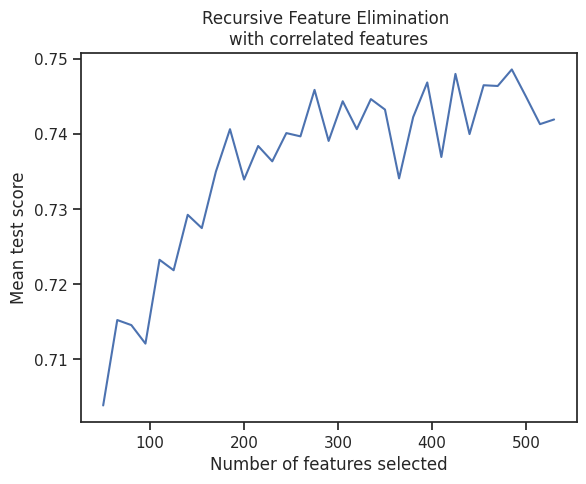

In [ ]:
# Plot results
cv_results = pd.DataFrame(selector_Huber.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
# Number of features selected
selector_Huber.n_features_

485

In [ ]:
# Save model
with open("selector_Huber.pickle", "wb") as fh:
  pickle.dump(selector_Huber, fh)

In [38]:
# Load model
with open(r"selector_Huber.pickle", "rb") as input_file:
  selector_Huber = pickle.load(input_file)

In [39]:
# Create new DF with selected features
input_Huber = input.iloc[:,selector_Huber.get_support()]
input_Huber

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,NumValenceElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE3_D,VR1_D,TopoPSA,SRW5,XLogP
0,0.77,0.28,0.40,0.82,0.07,0.41,0.38,0.42,0.61,0.53,...,0.33,0.55,0.00,0.00,0.02,0.91,0.00,0.26,0.71,0.22
1,0.72,0.21,0.40,0.76,0.03,0.32,0.23,0.36,0.79,0.53,...,0.92,0.00,0.00,0.00,0.08,0.95,0.00,0.23,0.00,0.34
2,0.76,0.24,0.39,0.89,0.03,0.42,0.39,0.42,0.61,0.41,...,0.60,0.00,0.00,0.00,0.02,0.91,0.00,0.26,0.00,0.24
3,0.67,0.03,0.76,0.61,0.02,0.29,0.29,0.46,0.67,0.67,...,1.00,0.00,0.00,0.00,0.30,0.97,0.00,0.32,0.00,0.30
4,0.76,0.13,0.37,0.95,0.06,0.41,0.36,0.44,0.67,0.62,...,0.74,0.00,0.00,0.00,0.21,0.96,0.00,0.34,0.46,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.59,0.01,0.82,0.96,0.04,0.48,0.47,0.32,0.45,0.53,...,0.52,0.57,0.45,0.57,0.17,0.94,0.00,0.15,0.00,0.35
8511,0.57,0.11,0.84,0.88,0.02,0.44,0.44,0.32,0.45,0.46,...,0.43,0.42,0.38,0.28,0.13,0.94,0.00,0.15,0.00,0.41
8512,0.63,0.01,0.82,0.76,0.03,0.48,0.47,0.34,0.45,0.50,...,0.65,0.38,0.31,0.00,0.11,0.94,0.00,0.15,0.00,0.38
8513,0.62,0.03,0.82,0.70,0.04,0.40,0.39,0.34,0.45,0.65,...,0.72,0.38,0.31,0.00,0.02,0.91,0.00,0.10,0.00,0.36


In [ ]:
kf = KFold(n_splits=5)
score = cross_val_score(HuberRegressor, input_Huber, output, cv=kf, scoring='r2')
show_values = ["HuberRegressor", np.round(np.mean(score), 2)]
print("{:>30} {:>30}".format(*show_values), np.round(score, 2))

                HuberRegressor                           0.75 [0.84 0.79 0.74 0.68 0.7 ]


#### **ExtraTreesRegressor**

In [ ]:
# RFE ExtraTrees Regressor
selector_ExtraTrees = RFECV(ExtraTreesRegressor, step=15,
                 min_features_to_select=50,
                 cv=5,
                 verbose=4
                 )

selector_ExtraTrees.fit(input,output)

Fitting estimator with 530 features.
Fitting estimator with 515 features.
Fitting estimator with 500 features.
Fitting estimator with 485 features.
Fitting estimator with 470 features.
Fitting estimator with 455 features.
Fitting estimator with 440 features.
Fitting estimator with 425 features.
Fitting estimator with 410 features.
Fitting estimator with 395 features.
Fitting estimator with 380 features.
Fitting estimator with 365 features.
Fitting estimator with 350 features.
Fitting estimator with 335 features.
Fitting estimator with 320 features.
Fitting estimator with 305 features.
Fitting estimator with 290 features.
Fitting estimator with 275 features.
Fitting estimator with 260 features.
Fitting estimator with 245 features.
Fitting estimator with 230 features.
Fitting estimator with 215 features.
Fitting estimator with 200 features.
Fitting estimator with 185 features.
Fitting estimator with 170 features.
Fitting estimator with 155 features.
Fitting estimator with 140 features.
F

RFECV(cv=5, estimator=ExtraTreesRegressor(), min_features_to_select=50, step=15,
      verbose=4)

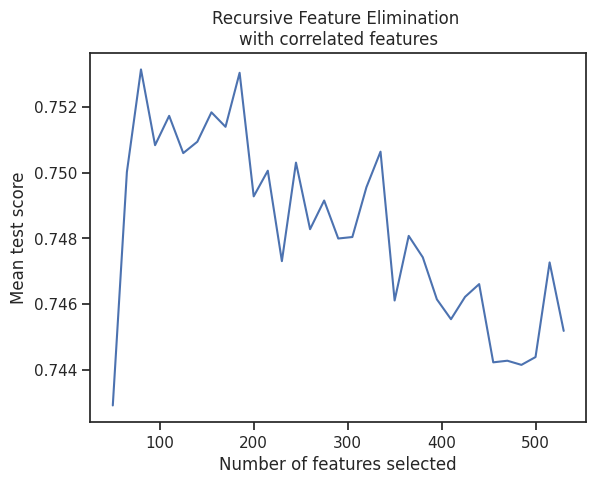

In [ ]:
# Plot results
cv_results = pd.DataFrame(selector_ExtraTrees.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
# plt.ylim(0, 1)
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
   #yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
# Number of features selected
selector_ExtraTrees.n_features_

80

In [ ]:
# Save model
with open("selector_ExtraTrees.pickle", "wb") as fh:
  pickle.dump(selector_ExtraTrees, fh)

In [40]:
# Load model
with open(r"selector_ExtraTrees.pickle", "rb") as input_file:
  selector_ExtraTrees = pickle.load(input_file)

In [41]:
# Create new DF with selected features
input_ExtraTrees = input.iloc[:,selector_ExtraTrees.get_support()]
input_ExtraTrees

,BCUT2D_MWLOW,BCUT2D_MRHI,BalabanJ,BertzCT,Chi0n,HallKierAlpha,SMR_VSA7,SlogP_VSA12,SlogP_VSA8,VSA_EState4,...,GGI7,GGI8,JGI1,JGI4,JGI5,JGI7,JGI8,JGI9,TopoPSA,XLogP
0,0.52,0.34,0.51,0.54,0.39,0.46,0.30,0.00,0.46,0.30,...,0.09,0.10,0.43,0.36,0.32,0.33,0.55,0.00,0.26,0.22
1,0.54,0.34,0.73,0.41,0.23,0.55,0.35,0.16,0.46,0.25,...,0.02,0.00,0.44,0.42,0.30,0.92,0.00,0.00,0.23,0.34
2,0.52,0.34,0.73,0.51,0.42,0.46,0.30,0.00,0.46,0.30,...,0.16,0.00,0.53,0.41,0.38,0.60,0.00,0.00,0.26,0.24
3,0.51,0.15,0.68,0.43,0.29,0.33,0.39,0.00,0.46,0.28,...,0.16,0.00,0.37,0.41,0.37,1.00,0.00,0.00,0.32,0.30
4,0.51,0.34,0.57,0.60,0.36,0.41,0.30,0.00,0.46,0.30,...,0.18,0.00,0.50,0.37,0.42,0.74,0.00,0.00,0.34,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8510,0.48,0.13,0.43,0.55,0.46,0.27,0.34,0.00,0.50,0.36,...,0.28,0.38,0.41,0.51,0.31,0.52,0.57,0.45,0.15,0.35
8511,0.53,0.12,0.54,0.46,0.46,0.30,0.39,0.00,0.52,0.33,...,0.23,0.36,0.40,0.42,0.24,0.43,0.42,0.38,0.15,0.41
8512,0.50,0.13,0.52,0.57,0.47,0.27,0.29,0.00,0.52,0.32,...,0.32,0.17,0.29,0.49,0.32,0.65,0.38,0.31,0.15,0.38
8513,0.51,0.12,0.49,0.52,0.40,0.30,0.34,0.00,0.52,0.33,...,0.25,0.12,0.34,0.52,0.32,0.72,0.38,0.31,0.10,0.36


In [ ]:
kf = KFold(n_splits=5)
score = cross_val_score(ExtraTreesRegressor, input_ExtraTrees, output, cv=kf, scoring='r2')
show_values = ["ExtraTreesRegressor", np.round(np.mean(score), 2)]
print("{:>30} {:>30}".format(*show_values), np.round(score, 2))

           ExtraTreesRegressor                           0.76 [0.8  0.78 0.78 0.72 0.69]


### Apply Grid Search CV

#### HistGradientBoostingRegressor

In [42]:
hgb_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "max_iter": [200, 500, 1000],
    "max_depth": [3, 5, 7],
    "min_samples_leaf": [5, 10, 20]
}
hgb_grid = GridSearchCV(HistGradientBoostingRegressor(), hgb_params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
hgb_grid.fit(input, output)
print(f"Best model for HistGradientBoostingRegressor: {hgb_grid.best_params_} with R2: {hgb_grid.best_score_:.4f}\n")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best model for HistGradientBoostingRegressor: {'learning_rate': 0.05, 'max_depth': 5, 'max_iter': 1000, 'min_samples_leaf': 5} with R2: 0.7714



#### LGBMRegressor

In [43]:
lgbm_params = {
    "learning_rate": [0.005, 0.01, 0.05],
    "n_estimators": [300, 500, 700],
    "max_depth": [3, 5, 7],
    "num_leaves": [20, 31, 50],
    "min_child_samples": [10, 20, 50]
}
lgbm_grid = GridSearchCV(LGBMRegressor(verbosity=-1), lgbm_params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
lgbm_grid.fit(input_LGBM, output)
print(f"Best model for LGBMRegressor: {lgbm_grid.best_params_} with R2: {lgbm_grid.best_score_:.4f}\n")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best model for LGBMRegressor: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 10, 'n_estimators': 700, 'num_leaves': 20} with R2: 0.7783



#### SVR

In [ ]:
svr_params = {
    "C": [10, 50, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", 0.01, 0.1]
}
svr_grid = GridSearchCV(SVR(), svr_params, cv=5, scoring='r2', n_jobs=-1, verbose=4)
svr_grid.fit(input, output)
print(f"Best model for SVR: {svr_grid.best_params_} with R2: {svr_grid.best_score_:.4f}\n")

Entrenando SVR...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


#### NuSVR

In [ ]:
nusvr_params = {
    "nu": [0.1, 0.25, 0.5],
    "C": [10, 50, 100],
    "kernel": ["linear", "rbf"]
}
nusvr_grid = GridSearchCV(NuSVR(), nusvr_params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
nusvr_grid.fit(input, output)
print(f"Best model for NuSVR: {nusvr_grid.best_params_} with R2: {nusvr_grid.best_score_:.4f}\n")

#### KernelRidge

In [ ]:
krr_params = {
    "alpha": [1e-2, 1e-1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": [None, 0.01, 0.1, 1]
}
krr_grid = GridSearchCV(KernelRidge(), krr_params, cv=5, scoring='r2', n_jobs=-1, verbose=1)
krr_grid.fit(input, output)
print(f"Best model for KernelRidge: {krr_grid.best_params_} with R2: {krr_grid.best_score_:.4f}\n")

#### HuberRegressor

In [ ]:
huber_params = {
    "alpha": [1e-6, 1e-5, 1e-4],
    "epsilon": [1.25, 1.5, 1.75]
}
huber_grid = GridSearchCV(HuberRegressor(), huber_params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
huber_grid.fit(input_Huber, output)
print(f"Best model for HuberRegressor: {huber_grid.best_params_} with R2: {huber_grid.best_score_:.4f}\n")

#### ExtraTreesRegressor

In [ ]:
print("Entrenando ExtraTreesRegressor...")
extra_params = {
    "n_estimators": [300, 500, 700],
    "max_depth": [10, 20, 30],
    "min_samples_split": [5, 10, 20]
}
extra_grid = GridSearchCV(ExtraTreesRegressor(), extra_params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
extra_grid.fit(input_ExtraTrees, output)
print(f"Best model for ExtraTreesRegressor: {extra_grid.best_params_} with R2: {extra_grid.best_score_:.4f}\n")